In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [5]:
input_image = cv.imread("head_mri.jpg",0)
input_image.shape

(600, 652)

In [6]:
scale_percent = 20 # percent of original size
width = int(input_image.shape[1] * scale_percent / 100)
height = int(input_image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img = cv.resize(input_image, dim, interpolation = cv.INTER_AREA)
img = np.pad(img, [(10, ), (10, )], mode='constant')

In [7]:
img.shape

(140, 150)

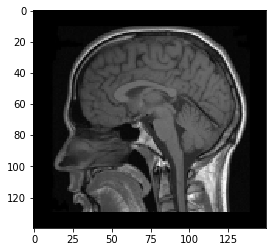

In [8]:
plt.imshow(img,cmap='gray')
#plt.imshow(input_image[:,:,2])

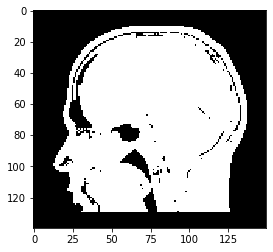

In [9]:
ret,binThresh = cv.threshold(img,30,255,cv.THRESH_BINARY)
plt.imshow(binThresh,cmap='gray')

In [10]:
edges = binThresh

In [11]:
cnts = cv.findContours(binThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    cv.drawContours(binThresh,[c], 0, (255,255,255), -1)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (20,20))
mask = cv.morphologyEx(binThresh, cv.MORPH_OPEN, kernel, iterations=2)
contour = binThresh.astype(float) / 255

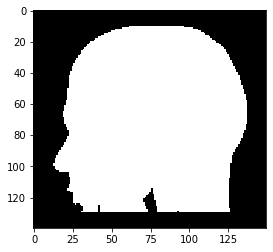

In [12]:
plt.imshow(contour,cmap='gray')

In [13]:
edges = cv.Canny(binThresh,250,250)
norm_edges = edges/255

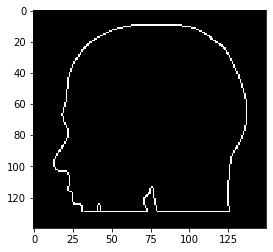

In [18]:
plt.imshow(norm_edges,cmap='gray')

# Slope Chain Code

In [15]:
def getNextSlope(ima,rad_max,coordPrev,coord):
    vect_prev = coord-coordPrev
    yc = coord[0]
    xc = coord[1]
    for rad in range(int(rad_max),int(rad_max/2),-1):
        for i in range(yc-rad,yc+rad+1):
            j2 = int(xc-np.sqrt(rad**2-(yc-i)**2))
            coord2 = np.array([i,j2])
            if ima[i][j2]>0:
                vect = coord2-coord
                theta = np.arctan2(vect[0],vect[1])-np.arctan2(vect_prev[0],vect_prev[1])
                if theta>np.pi:
                    theta -= 2*np.pi
                m = theta/np.pi
                if np.abs(m)<1-1/rad:
                    return coord2,-m
        for i in range(yc+rad,yc-rad-1,-1):
            j1 = int(xc+np.sqrt(rad**2-(yc-i)**2))
            coord1 = np.array([i,j1])
            if ima[i][j1]>0:
                vect = coord1-coord
                theta = np.arctan2(vect[0],vect[1])-np.arctan2(vect_prev[0],vect_prev[1])
                if theta>np.pi:
                    theta -= 2*np.pi
                m = theta/np.pi
                if np.abs(m)<1-1/rad:
                    return coord1,m
    return None,None

In [16]:
def slopeChainCode(ima,rad,segments):
    chain=[]
    points=[]
    for j in range(len(ima[0])):
        for i in range(len(ima)):
            if ima[i][j]==1:
                coord = np.array([i,j])
                points.append(list(coord))
                coord_prev = np.array([i,j+rad])
                new_coord,new_slope = getNextSlope(ima,rad,coord_prev,coord)
                #print(coord,new_coord,new_slope)
                if new_slope:
                    coord_prev = coord
                    coord = new_coord
                while not (new_slope is None):
                    points.append(list(coord))
                    new_coord,new_slope = getNextSlope(ima,rad,coord_prev,coord)
                    #print(coord,new_coord,new_slope)
                    if not (new_slope is None):
                        coord_prev = np.array(coord)
                        coord = np.array(new_coord)
                        chain.append(new_slope)
                    if len(points)>segments:
                        break
                pt = np.array(points).T
                fig,axs = plt.subplots(2,figsize=(16,16))
                axs[0].imshow(ima,'gray')
                dib = axs[0].scatter(pt[1],pt[0])
                axs[1].plot(chain)
                axs[1].grid()
                plt.show()
                return chain

In [35]:
def discreteTortuosity(ssc):
    return np.sum(np.abs(ssc))

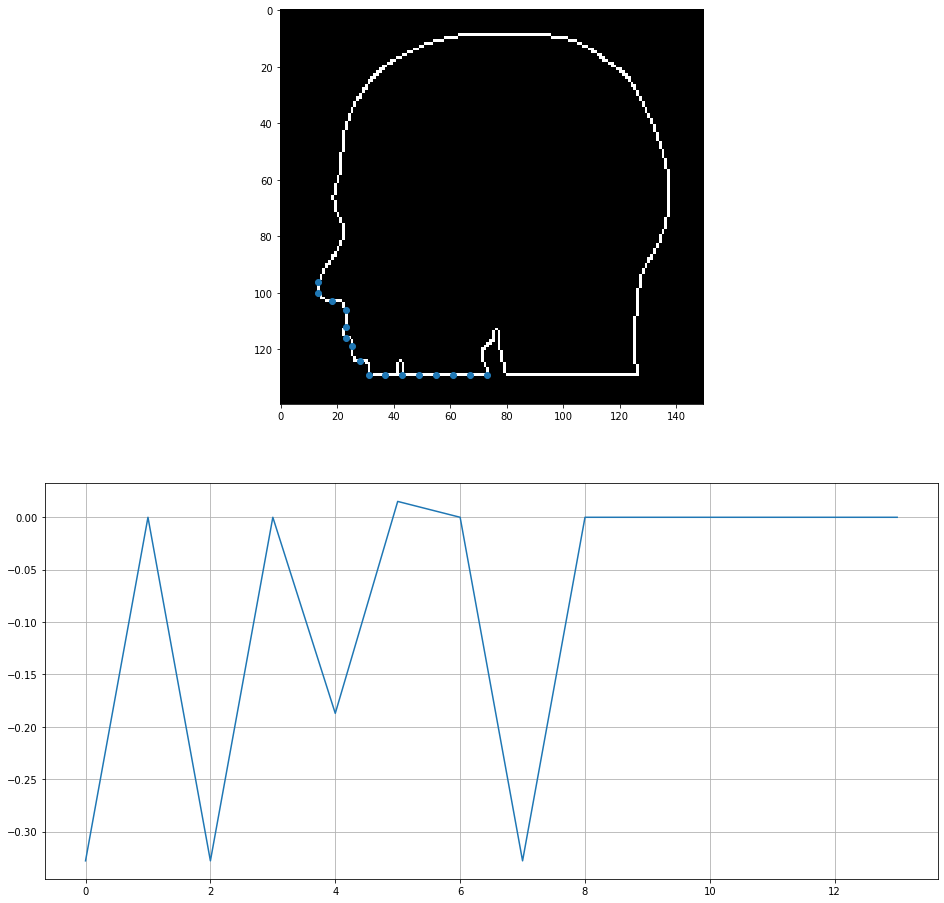

In [30]:
ssc = slopeChainCode(norm_edges,6,600)

In [33]:
print("Slope Chain Code: ",ssc)

Slope Chain Code:  [-0.32797913037736937, 0.0, -0.32797913037736937, -0.0, -0.1871670418109988, 0.01514617218836816, 0.0, -0.32797913037736937, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [37]:
print("Discrete Tortuosity: ",discreteTortuosity(ssc))

Discrete Tortuosity:  1.186250605131475


## another aproach

Se utilizan dos pixeles de distancia para cada segmento considerando los tres pixeles de cada lado de un pixel dado, por lo que se tienen hasta 12 símbolos para representar la resolución de la cadena. Por tanto, se tiene una resolución de 30°

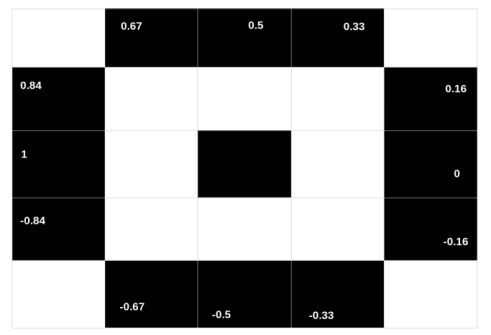

In [17]:
def getInitialPixel(ima):
    for i in range(len(ima)):
        for j in range(len(ima[0])):
            if ima[i][j]>0:
                return i,j

In [18]:
def slopeChainCode(ima):
    code_string = ""
    ones = 0
    threes = 0
    points = []
    i,j = getInitialPixel(ima)
    points.append([i,j])
    ant = [i,j]
    act = [i+1,j] # counterclockwise tracking
    break_loop = 0
    edg_img = np.zeros((ima.shape))
    plt_ima = ima.copy()
    while ones!=4+threes and break_loop<20000: # iterate till closed loop
        break_loop += 1
        pix = ima[act[0]-1:act[0]+1,act[1]-1:act[1]+1]
        pix_sum = np.sum(pix)
        points.append(act[:])
        edg_img[act[0],act[1]] = 1
        if pix_sum==1:
            ones += 1
            act, code_string = walk_corner1(pix,act,code_string)
        elif pix_sum==2:
            if pix[0][0]==pix[0][1]:
                if pix[0][0]==1:
                    act[1] +=1
                    code_string += "0, "
                else:
                    act[1] -=1
                    code_string += "1, "
            elif pix[0][0]==0:
                act[0] +=1
                code_string += "-0.67, "
            else:
                act[0] -=1
                code_string += "0.67, "
        else:
            threes +=1
            act,code_string = walk_corner3(pix,act,code_string)
        if i%2==0:
            cv.line(plt_ima, (ant[1],ant[0]), (act[1],act[0]), (84,84,84), 1)
            ant[0] = act[0]
            ant[1] = act[1]
    pt = np.array(points).T
    fig = plt.figure(figsize=(10,6))
    plt.imshow(plt_ima,'gray')
    #dib = plt.scatter(pt[1],pt[0],2,c=np.arange(len(pt[0])),cmap='viridis')
    #plt.colorbar(dib)
    plt.show()
    return code_string,pt,edg_img

In [19]:
def walk_corner1(pix,act,code_string):
    if pix[0][0]>0:
        return [act[0]-1,act[1]], code_string+"0.16, "
    elif pix[0][1]>0:
        return [act[0],act[1]+1], code_string+"-0.16, "
    elif pix[1][0]>0:
        return [act[0],act[1]-1], code_string+"0.84, "
    else:
        return [act[0]+1,act[1]], code_string+"-0.84, "

In [20]:
def walk_corner3(pix,act,code_string):
    if pix[0][0]==0:
        return [act[0],act[1]-1], code_string+"-0.67, "
    elif pix[0][1]==0:
        return [act[0]-1,act[1]], code_string+"0.67, "
    elif pix[1][0]==0:
        return [act[0]+1,act[1]], code_string+"-0.33, "
    elif pix[1][1]==0:
        return [act[0],act[1]+1], code_string+"0.33, "
    else:
        return [act[0]+1,act[1]+1], code_string+"-0.33, "

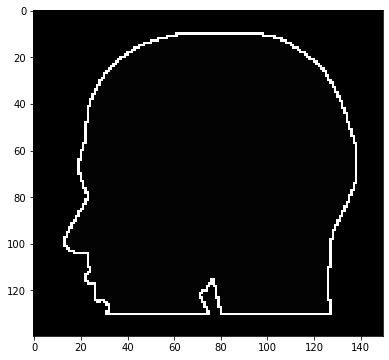

In [22]:
sccode,pt,edges_img = slopeChainCode(contour)

In [16]:
print(sccode)

-0.67, 1, 1, 1, -0.84, -0.67, 1, 1, 1, -0.84, -0.67, 1, 1, -0.84, -0.67, 1, 1, -0.84, -0.67, 1, -0.84, -0.67, 1, -0.84, -0.67, -0.84, -0.67, 1, -0.84, -0.67, -0.84, -0.67, 1, -0.84, -0.67, -0.84, -0.67, -0.84, -0.67, -0.84, -0.67, -0.84, -0.67, -0.84, -0.67, -0.84, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.67, -0.84, -0.67, -0.67, -0.67, -0.67, -0.67, -0.67, -0.67, -0.84, -0.67, -0.67, -0.67, -0.67, -0.67, -0.67, -0.67, -0.67, -0.67, -0.84, -0.67, -0.67, -0.67, -0.84, -0.67, -0.67, -0.67, -0.67, -0.84, -0.67, -0.67, -0.67, -0.67, -0.67, -0.16, -0.33, -0.67, -0.67, -0.16, -0.33, -0.67, -0.67, -0.16, -0.33, -0.67, -0.16, -0.33, -0.67, -0.67, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.84, -0.67, -0.67, -0.67, -0.16, -0.33, -0.16, -0.33, -0.16,